# ITI113 - Machine Learning & Operations Project

Submitted by: Ng Yong Huat  
Admin No:     8057714P

## Revision Note Tracking

In [4]:
%%writefile revision_note.txt
Rev 08: change num_filters_1 = 64 of best model from 32  
Rev 09: add scaler  
Rev 10: add streamlit  
Rev 11: Script housekeeping, added export_to_excel(), plot_confusion_matrices()  
Rev 12: Reduced run for more efficient script cleanup. Did up to baseline model 1D-CNN.  
Rev 13: Reverse back to original run parameters  
Rev 14: Fixed the scaling problem in the streamlit, achieving good accuracy on inference prediction.
Rev 15: Enhancement on graph plots, modified and upload revision_note.txt, save encoder with joblib.
Rev 16: Fast test model: Fix the sorted_classification_report() function. Use df, but rearranged the columns
Rev 16A:Fast test model: added accuracy, tested ok
Rev 18: Added accuracy in print and excel. Reset all epochs for full run
Rev 19: Working revision. Added list_n_file for feature importance for analysis,
Rev 20: Minor cleanup. Updated markdown
Rev_21: Working revision. Update changes in Rev16C, clean up all import 
Final:  Working revision for submission. Included the McNemar's Hypothesis Testing                                                                 

Writing revision_note.txt


In [5]:
# download revision_note.txt to local folder for archiving
import shutil
shutil.move("revision_note.txt",r"C:\Users\Ng Yong Huat\Documents\YH's HP PC\3 NYP\Applied AI\ITI-113 Project\Dataset\revision_note.txt")

"C:\\Users\\Ng Yong Huat\\Documents\\YH's HP PC\\3 NYP\\Applied AI\\ITI-113 Project\\Dataset\\revision_note.txt"

## Overall Flow Chart

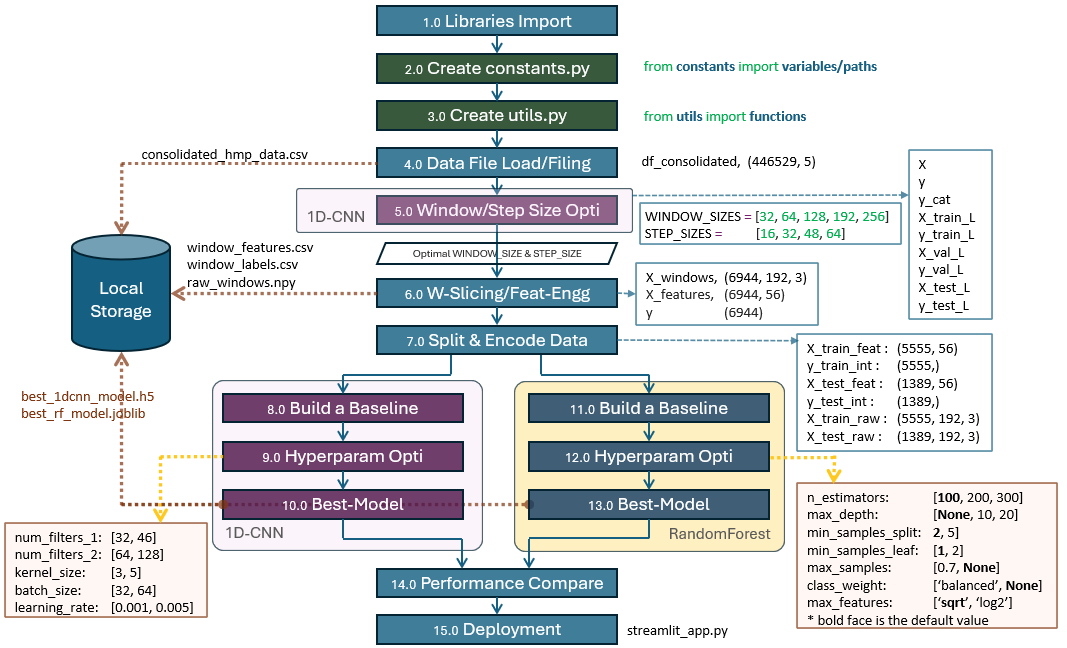

## 1.0 __Libraries Import__

In [9]:
# ---- Core Import ----
import os
import glob
import joblib
import numpy as np
import pandas as pd
from datetime import datetime

# ---- Visualization ----
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars

# ---- Machine Learning ----
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from itertools import product
from joblib import dump, load
from operator import itemgetter
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier, 
    StackingClassifier
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    auc, precision_recall_curve, roc_auc_score, roc_curve,
    classification_report, confusion_matrix, 
    average_precision_score, balanced_accuracy_score,
    matthews_corrcoef, fbeta_score, hamming_loss
)
from sklearn.model_selection import (
    train_test_split, cross_val_score,
    GridSearchCV, StratifiedKFold
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, 
    label_binarize, LabelEncoder
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import(
    Conv1D, MaxPooling1D, 
    GlobalAveragePooling1D, 
    Dense, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier

# ---- Warnings ----
import warnings
warnings.filterwarnings('ignore')

# ---- Global Plotting Font Size ----
# Global font size setting for plots
plt.rcParams.update({
    'font.size': 12,              # Global font size
    'axes.titlesize': 14,         # Title
    'axes.labelsize': 12,         # X and Y labels
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 12
})


## 2.0 __Create constants.py__ - Centralized Management of Variables & File Directors/Filename

In [11]:
%%writefile constants.py
import os
# ==========================================================================================
# HOW TO USE IT: from constants import variable/dir_name
# ==========================================================================================
WINDOW_SIZE = 192
STEP_SIZE   = 48   # 25% of window. Practical guide: 25% to 50%

main_folder = r"C:\Users\Ng Yong Huat\Documents\YH's HP PC\3 NYP\Applied AI\ITI-113 Project\Dataset"

local_raw_data_dir       = os.path.join(main_folder, "HMP_Dataset")
local_compiled_data_path = os.path.join(main_folder, "Consolidated", "v1", "consolidated_hmp_data.csv")
local_processed_data_dir = os.path.join(main_folder, "Processed_Data")
local_joblib_model_dir   = os.path.join(main_folder, "joblib_model")
local_eval_data_dir      = os.path.join(main_folder, "Eval_Results")


Overwriting constants.py


## Local Project Data Storage Structure

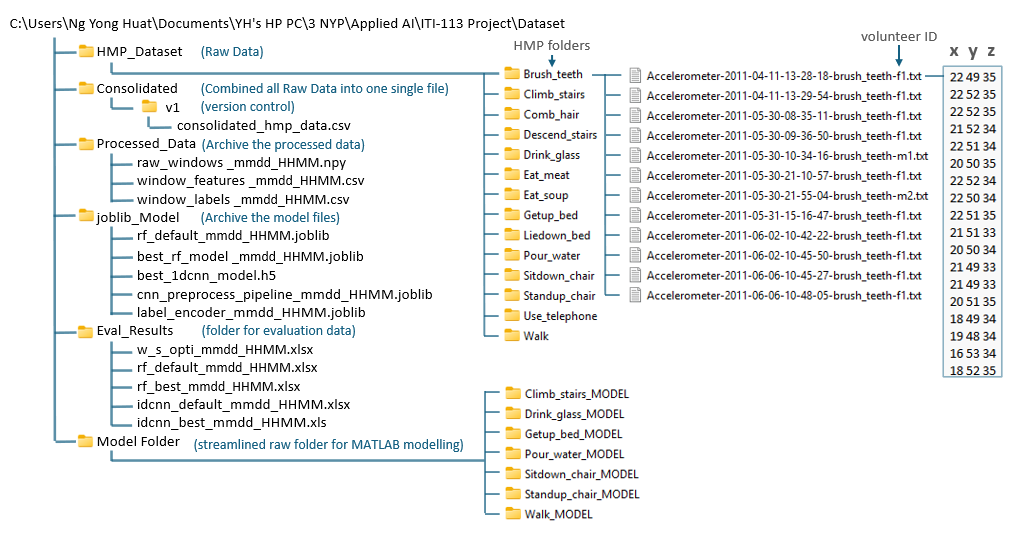

## 3.0 __Create utils.py__ - Centralized Manangement of all Defined Function & Class

In [15]:
%%writefile utils.py
import os
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
from io import StringIO
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from openpyxl import Workbook
from constants import WINDOW_SIZE, STEP_SIZE, local_compiled_data_path,local_eval_data_dir
# ==========================================================================================
# HOW TO USE IT: from utils import function_name
#   1.  integrate_hmp_dataset         (root_folder)
#   2.  extract_features              (window)
#   3.  process_windows               (df)
#   4.  sorted_classification_report  (y_true, y_pred, target_names=None, sort_by='recall')
#   5.  export_to_excel               (y_test_int, y_pred_rf, class_names, excel_filename)
#   6.  export_to_excel_2             (y_test_int, y_pred_cnn, class_names, excel_filename, hyperparams=None)
#   7.  create_sliding_windows        (data, labels, window_size, step_size, label_strategy="last")
#   8.  build_cnn                     (input_shape, num_classes)
#   9.  build_cnn_opti                (input_shape, num_classes, num_filters_1, num_filters_2, kernel_size, learning_rate)
#   10. load_and_prepare_data         (window_size, step_size)
#   11. TimeSeriesScaler              (BaseEstimator, TransformerMixin)
#   12. plot_confusion_matrices       (y_true, y_pred, class_names, model_name)
#   13. get_timestamp                 ()
#   14. get_metrics                   (y_true, y_pred)
#   15. list_n_file_feat_importance   (model, feature_names, output_dir=".", output_filename="feature_importance")
# ==========================================================================================
# No.1: Dataset integration
def integrate_hmp_dataset(root_folder):
    data = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                hmp = os.path.basename(root)
                volunteer = file.split('-')[-1].replace('.txt', '').strip()
                try:
                    df_file = pd.read_csv(file_path, sep=r'\s+', header=None, names=['x','y','z'], engine='python')
                    df_file['HMP'] = hmp
                    df_file['Volunteer'] = volunteer
                    data.append(df_file)
                except Exception as e:
                    print(f"Skipping {file_path} due to error: {e}")
    if data:
        return pd.concat(data, ignore_index=True)
    else:
        raise ValueError("No valid .txt files found.")

# ==========================================================================================
# No.2: Feature extraction
def extract_features(window):
    features = {}
    axes = {'x':0, 'y':1, 'z':2}
    for axis, idx in axes.items():
        data = window[:, idx]
        features[f'{axis}_mean'] = np.mean(data)
        features[f'{axis}_std'] = np.std(data)
        features[f'{axis}_var'] = np.var(data)
        features[f'{axis}_max'] = np.max(data)
        features[f'{axis}_min'] = np.min(data)
        features[f'{axis}_median'] = np.median(data)
        features[f'{axis}_mad'] = np.median(np.abs(data - np.median(data)))
        features[f'{axis}_range'] = np.ptp(data)
        features[f'{axis}_energy'] = np.sum(data**2)
        features[f'{axis}_auc'] = np.trapz(np.abs(data))
        features[f'{axis}_zcr'] = ((data[:-1] * data[1:]) < 0).sum() / len(data)
        for p in [10, 25, 75, 90]:
            features[f'{axis}_p{p}'] = np.percentile(data, p)
    # Frequency-domain
    for axis, idx in axes.items():
        fft = np.abs(np.fft.rfft(window[:, idx]))
        if len(fft) > 0:
            features[f'{axis}_dom_freq'] = np.argmax(fft)
            features[f'{axis}_psd'] = np.sum(fft**2)
    # Cross-axis
    features['xy_corr'] = np.corrcoef(window[:,0], window[:,1])[0,1]
    features['yz_corr'] = np.corrcoef(window[:,1], window[:,2])[0,1]
    features['xz_corr'] = np.corrcoef(window[:,0], window[:,2])[0,1]
    # Magnitude
    mag = np.linalg.norm(window, axis=1)
    features['mag_mean'] = np.mean(mag)
    features['mag_std'] = np.std(mag)
    return features

# ==========================================================================================
# No.3: Sliding window processing
def process_windows(df):
    windows, features_list, labels = [], [], []
    for hmp, group in tqdm(df.groupby('HMP'), desc="Processing Activities"):
        values = group[['x','y','z']].values
        for i in range(0, len(values)-WINDOW_SIZE+1, STEP_SIZE):
            window = values[i:i+WINDOW_SIZE]
            windows.append(window)
            features_list.append(extract_features(window))
            labels.append(hmp)
    return np.array(windows), pd.DataFrame(features_list), np.array(labels)

# ==========================================================================================
# No.4: Sorted classification report
def sorted_classification_report(y_true, y_pred, target_names=None, sort_by='recall'):
    valid_metrics = {'precision', 'recall', 'f1-score'}
    if sort_by not in valid_metrics:
        raise ValueError(f"sort_by must be one of {valid_metrics}, got '{sort_by}'")
    report_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    accuracy = report_dict['accuracy']  # Extract accuracy
    rows = []
    for class_name in (target_names if target_names is not None else report_dict.keys()):
        if class_name in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        row = report_dict[class_name]
        row['class'] = class_name
        rows.append(row)
    rows_sorted = sorted(rows, key=lambda r: r[sort_by], reverse=True)
    # Convert to DataFrame and reorder columns (class first)
    df_sorted = pd.DataFrame(rows_sorted)
    column_order = ['class'] + [col for col in df_sorted.columns if col != 'class']
    df_sorted = df_sorted[column_order]   
    # Format all numeric columns to 3 decimal places
    numeric_cols = ['precision', 'recall', 'f1-score']
    df_sorted[numeric_cols] = df_sorted[numeric_cols].apply(lambda x: round(x, 3))   
    return df_sorted, accuracy # Now returns both DataFrame and accuracy

# ==========================================================================================
# No.5: Export reports to Excel
def export_to_excel(y_test_int, y_pred, class_names, excel_filename, hyperparams=None):
    timestamp = datetime.now().strftime("%m%d_%H%M")
    base, _ = os.path.splitext(excel_filename)
    excel_filename = f"{base}_{timestamp}.xlsx"
    with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
        for metric in ['precision','recall','f1-score']:
            df_report = sorted_classification_report(y_test_int, y_pred, class_names, sort_by=metric)
            df_report.to_excel(writer, sheet_name=f"Sorted_by_{metric}", index=False)
        if hyperparams:
            pd.DataFrame(list(hyperparams.items()), columns=["Parameter","Value"]).to_excel(writer, sheet_name="Hyperparameters", index=False)
    print(f"Evaluation results saved to: {excel_filename}")

# ======================================================================================
# No.6: Export reports to Excel 2
def export_to_excel_2(y_test_int, y_pred_cnn, class_names, excel_filename, hyperparams=None):
    timestamp = datetime.now().strftime("%m%d_%H%M")
    base, ext = os.path.splitext(excel_filename)
    excel_filename = f"{base}_{timestamp}.xlsx"  
    with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
        for metric in ['precision', 'recall', 'f1-score']:
            report_df, accuracy = sorted_classification_report(y_test_int, y_pred_cnn, class_names, sort_by=metric)
            # Add accuracy as a new row in the DataFrame
            accuracy_row = pd.DataFrame({
                'class': ['accuracy'],
                'precision': [accuracy],
                'recall': [accuracy],
                'f1-score': [accuracy],
                'support': [len(y_test_int)]  # Optional: Include support count
            })
            report_df = pd.concat([report_df, accuracy_row], ignore_index=True)          
            report_df.to_excel(writer, sheet_name=f"Sorted_by_{metric}", index=False)
            # Save hyperparameters if provided
            if hyperparams:
                params_df = pd.DataFrame(list(hyperparams.items()), columns=["Parameter", "Value"])
                params_df.to_excel(writer, sheet_name="Hyperparameters", index=False)
        print(f"Evaluation results saved to: {excel_filename}")

# ==========================================================================================
# No. 7: Sliding windows for ML models
def create_sliding_windows(data, labels, window_size, step_size, label_strategy="last"):
    X, y = [], []
    n_samples = len(data)
    for start in range(0, n_samples - window_size + 1, step_size):
        end = start + window_size
        window_data = data[start:end]
        window_labels = labels[start:end]
        if label_strategy == "last":
            label = window_labels[-1]
        elif label_strategy == "middle":
            label = window_labels[window_size//2]
        elif label_strategy == "majority":
            label = Counter(window_labels).most_common(1)[0][0]
        elif label_strategy == "strict":
            if len(set(window_labels)) != 1:
                continue
            label = window_labels[0]
        else:
            raise ValueError(f"Unknown label_strategy: {label_strategy}")
        X.append(window_data)
        y.append(label)
    return np.array(X), np.array(y)

# ==========================================================================================
# No. 8: CNN builders
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    
# ==========================================================================================
# No. 9: CNN builders for opti
def build_cnn_opti(input_shape, num_classes, num_filters_1, num_filters_2, kernel_size, learning_rate):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(num_filters_1, kernel_size, activation='relu'),
        MaxPooling1D(2),
        Conv1D(num_filters_2, kernel_size, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# ==========================================================================================
# No. 10: load and prepare data
def load_and_prepare_data(window_size, step_size):
    # --- Load data ---
    df = pd.read_csv(local_compiled_data_path)
    # Encode labels
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['HMP'])
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Label mapping:", label_mapping)
    # Extract raw features and labels
    raw_data = df[['x', 'y', 'z']].values
    raw_labels = df['label'].values
    num_classes = len(label_mapping)
    # Create sliding windows
    X, y = create_sliding_windows(
        raw_data, raw_labels,
        window_size=window_size,
        step_size=step_size,
        label_strategy="strict"
    )  
    # Train/validation/test split
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=42,
        stratify=y_temp
    )
    return X_train, X_val, X_test, y_train, y_val, y_test, label_mapping

# ==========================================================================================
# No. 11: TimeSeriesScaler class
class TimeSeriesScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=None):
        self.scaler = scaler if scaler else StandardScaler()
    def fit(self, X, y=None):
        n_samples, n_timestamps, n_features = X.shape
        X_2d = X.reshape(-1, n_features)
        self.scaler.fit(X_2d)
        return self
    def transform(self, X):
        n_samples, n_timestamps, n_features = X.shape
        X_2d = X.reshape(-1, n_features)
        X_scaled = self.scaler.transform(X_2d)
        return X_scaled.reshape(n_samples, n_timestamps, n_features)

# ==========================================================================================
# No. 12: Confusion matrix plotting
def plot_confusion_matrices(y_true, y_pred, class_names, model_name, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    metrics = {"Precision (%)": cm.astype(float)/cm.sum(axis=0)[np.newaxis,:]*100,
               "Recall (%)": cm.astype(float)/cm.sum(axis=1)[:,np.newaxis]*100}
    for metric_name, cm_percent in metrics.items():
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
        fig.patch.set_facecolor('#f5f5f5')
        sns.heatmap(cm, annot=True, fmt='d', ax=ax1, xticklabels=class_names, yticklabels=class_names,
                    annot_kws={"size":10}, cbar_kws={"shrink":0.7}, linewidths=0.5, linecolor='gray', square=True,
                    cmap='Blues')
        ax1.set_title("Counts", fontsize=14)
        ax1.set_xlabel("Predicted Label", fontsize=10)
        ax1.set_ylabel("True Label", fontsize=10)
        ax1.set_facecolor('#ffffff')
        sns.heatmap(cm_percent, annot=True, fmt='.1f', ax=ax2, xticklabels=class_names, yticklabels=class_names,
                    annot_kws={"size":10}, cbar_kws={"shrink":0.7}, linewidths=0.5, linecolor='gray', square=True,
                    cmap='Greens' if metric_name=="Recall (%)" else 'Oranges')
        ax2.set_title(metric_name, fontsize=14)
        ax2.set_xlabel("Predicted Label", fontsize=10)
        ax2.set_ylabel("True Label", fontsize=10)
        ax2.set_facecolor('#ffffff')
        plt.suptitle(f"Confusion Matrix {model_name} - Counts & {metric_name}", fontsize=18)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()

# ==========================================================================================
# No. 13: Timestamp utility
def get_timestamp():
    return datetime.now().strftime("%m%d_%H%M")

# ==========================================================================================
# No. 14: Metrics for comparison
def get_metrics(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='macro'),
        'Recall': recall_score(y_true, y_pred, average='macro'),
        'F1-Score': f1_score(y_true, y_pred, average='macro')
    }
# ==========================================================================================
# No. 15: Metrics for comparison
def list_n_file_feat_importance(model, feature_names, output_dir=".", output_filename="RF_feature_importance"):
    # Get and sort feature importances (convert to percentage)
    importance = pd.Series(
        model.feature_importances_ * 100,
        index=feature_names
    ).sort_values(ascending=False).round(2)
    
    # Console output
    print(f"\nFeatures importance:\n{'=' * 32}")
    print("{:<30} {:<10}".format("Feature", "Factor"))  # Wider first column
    for feature, score in importance.items():
        print("{:<30} {:>10.2f}".format(feature, score))
    
    # Excel export
    excel_path = f"{output_dir}/{output_filename}_{get_timestamp()}.xlsx"
    (importance.reset_index()
              .rename(columns={'index': 'Feature', 0: 'Factor'})
              .to_excel(excel_path, index=False))
    
    print(f"\nFeature importance table saved to: {excel_path}")

# Example usage:
# list_n_file_feat_importance(best_model_rf, X_train_feat.columns, local_eval_data_dir)

Overwriting utils.py


## Import of Defined Variables, Data Directories/Path, Functions & Classes

__Ready__ to be called by the main script  
Keeps the main script __structured & tidy__

In [17]:
from constants import (
    WINDOW_SIZE,
    STEP_SIZE,
    local_raw_data_dir,
    local_joblib_model_dir,
    local_processed_data_dir,
    local_eval_data_dir,
    local_compiled_data_path
)
from utils import (
    integrate_hmp_dataset,
    extract_features,
    process_windows,
    sorted_classification_report,
    export_to_excel,
    export_to_excel_2,
    create_sliding_windows,
    build_cnn,
    build_cnn_opti,
    load_and_prepare_data,
    TimeSeriesScaler,
    plot_confusion_matrices,
    get_timestamp,
    get_metrics,
    list_n_file_feat_importance
)

## 4.0 __Data Files__

1. Download raw data (tree of folders & files) from source folder  
2. Consolidate all raw data into a single .csv file  
3. Upload consolidate file to local folder as archive  
4. Conduct brief EDA - check for missing, Nan, descriptive statistics

In [20]:
# Compile a consolidated dataset combining all the individual datafiles
# save compiled file back to local directory

# compiled data
df_consolidated = integrate_hmp_dataset(local_raw_data_dir)
# save to CSV
df_consolidated.to_csv(local_compiled_data_path)

# Initial Data Analysis
print(f"\nConsolidated data shape: {df_consolidated.shape}")
print(f"\nSample data view : \n{'=' * 40}")
print(df_consolidated.head())
print(f"\nPercentage of missing data in columns : \n{'=' * 40}")
print((df_consolidated.isnull().sum() / len(df_consolidated) * 100).round(2))
print(f"\nPercentage of Nan in columns : \n{'=' * 40}")
print((df_consolidated.isna().sum()/len(df_consolidated)*100).round(2))
print(f"\nStatistical Summary of x,y,z data : \n{'=' * 40}")
print(df_consolidated.describe().round(2))
print()
print(f"\ndf_consolidated.info() : \n{'=' * 40}")
print(df_consolidated.info())

Skipping C:\Users\Ng Yong Huat\Documents\YH's HP PC\3 NYP\Applied AI\ITI-113 Project\Dataset\HMP_Dataset\MANUAL.txt due to error: Expected 3 fields in line 25, saw 4. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping C:\Users\Ng Yong Huat\Documents\YH's HP PC\3 NYP\Applied AI\ITI-113 Project\Dataset\HMP_Dataset\README.txt due to error: 'utf-8' codec can't decode byte 0xe0 in position 2910: invalid continuation byte

Consolidated data shape: (446529, 5)

Sample data view : 
    x   y   z          HMP Volunteer
0  22  49  35  Brush_teeth        f1
1  22  49  35  Brush_teeth        f1
2  22  52  35  Brush_teeth        f1
3  22  52  35  Brush_teeth        f1
4  21  52  34  Brush_teeth        f1

Percentage of missing data in columns : 
x            0.0
y            0.0
z            0.0
HMP          0.0
Volunteer    0.0
dtype: float64

Percentage of Nan in columns : 
x            0.0
y            0.0
z            0.0
HMP          0.0
Volunteer

## 5.0 __Window_Size & Step_Size Optimization__ - Using 1D-CNN

In [22]:
# ===== CONFIG =====
DATA_PATH = local_compiled_data_path
WINDOW_SIZES = [32, 64, 128, 192, 256]   
STEP_SIZES =   [16, 32, 48, 64]
EPOCHS =       50
BATCH_SIZE =   64
EXCEL_FILENAME = "w_s_opti.xlsx"

df = pd.read_csv(DATA_PATH) # combined raw data, without feature-engineering

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['HMP'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)

# --- Store results ---
results = []

# Extract raw features and labels
raw_data = df[['x', 'y', 'z']].values
raw_labels = df['label'].values
num_classes = len(label_mapping)

# --- Grid search on window size and step size ---
for w in WINDOW_SIZES:
    for s in STEP_SIZES:
        print(f"\n=== Training with window_size={w}, step_size={s} ===")

        # Create windows, use "strict" to discard all mixed window at transition points
        X, y = create_sliding_windows(raw_data, raw_labels, window_size=w, step_size=s, label_strategy="strict" )
        y_cat = to_categorical(y, num_classes=num_classes)

        # Train/test split
        X_train_L, X_temp, y_train_L, y_temp = train_test_split(X, y_cat, test_size=0.3, random_state=42, stratify=y)
        X_val_L, X_test_L, y_val_L, y_test_L = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=np.argmax(y_temp, axis=1))

        # Create scaling pipeline
        scaling_pipeline = Pipeline([
            ('scaler', TimeSeriesScaler(StandardScaler()))
        ])

        # Fit-transform training, transform validation/test
        X_train_L = scaling_pipeline.fit_transform(X_train_L)
        X_val_L   = scaling_pipeline.transform(X_val_L)
        X_test_L  = scaling_pipeline.transform(X_test_L)
      
        # Build model
        model = build_cnn(input_shape=(w, 3), num_classes=num_classes)

        # Train
        history = model.fit(
            X_train_L, y_train_L,
            validation_data=(X_val_L, y_val_L),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0
        )

        # Evaluate
        train_acc = history.history['accuracy'][-1]
        val_acc = history.history['val_accuracy'][-1]
        test_loss, test_acc = model.evaluate(X_test_L, y_test_L, verbose=0)

        print(f"Train acc={train_acc:.4f}, Val acc={val_acc:.4f}, Test acc={test_acc:.4f}")

        results.append({
            "window_size": w,
            "step_size": s,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "test_acc": test_acc
        })

# --- Save to Excel ---
results_df = pd.DataFrame(results)
results_df.sort_values(by="val_acc", ascending=False, inplace=True)
# Split filename into name and extension
base, ext = os.path.splitext(EXCEL_FILENAME)
results_df.to_excel(f"{local_eval_data_dir}/{base}_{get_timestamp()}{ext}", index=False)
print(f"\nResults saved to {local_eval_data_dir}/{base}_{get_timestamp()}{ext}")
print("\n==================  Window_size and Step_size Optimization Completed =============================")
print(f"\n==================1D-CNN Window_size/Step_size Grid-Search Results =======================")
print(results_df)

Label mapping: {'Brush_teeth': 0, 'Climb_stairs': 1, 'Comb_hair': 2, 'Descend_stairs': 3, 'Drink_glass': 4, 'Eat_meat': 5, 'Eat_soup': 6, 'Getup_bed': 7, 'Liedown_bed': 8, 'Pour_water': 9, 'Sitdown_chair': 10, 'Standup_chair': 11, 'Use_telephone': 12, 'Walk': 13}

=== Training with window_size=32, step_size=16 ===
Train acc=0.6923, Val acc=0.6578, Test acc=0.6529

=== Training with window_size=32, step_size=32 ===
Train acc=0.6374, Val acc=0.6026, Test acc=0.6205

=== Training with window_size=32, step_size=48 ===
Train acc=0.6327, Val acc=0.6126, Test acc=0.6155

=== Training with window_size=32, step_size=64 ===
Train acc=0.6177, Val acc=0.5703, Test acc=0.5860

=== Training with window_size=64, step_size=16 ===
Train acc=0.7890, Val acc=0.7707, Test acc=0.7657

=== Training with window_size=64, step_size=32 ===
Train acc=0.7188, Val acc=0.6979, Test acc=0.7105

=== Training with window_size=64, step_size=48 ===
Train acc=0.6689, Val acc=0.6712, Test acc=0.6640

=== Training with win

### Results: Validation Accuracy Sorted by Window_Size and Step_Size

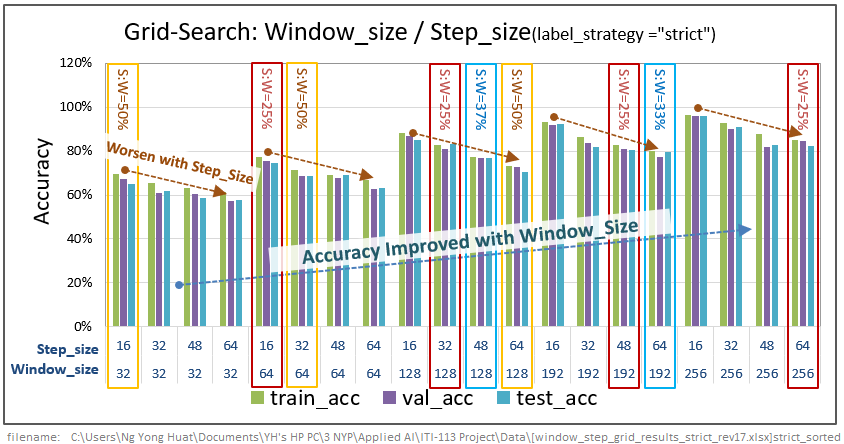

### Results: Sorted by Validation Accuracy 

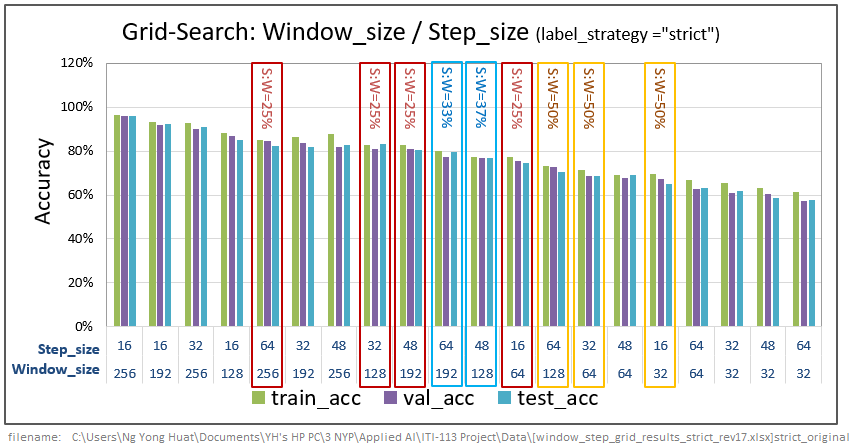

## 6.0 __EDA__ - Window-Slicing & Feature-Engineering

In [28]:
# update optimal values from 5.0
WINDOW_SIZE = WINDOW_SIZE
STEP_SIZE   = STEP_SIZE     # rules of thumb step:window = 25% to 50%

# Load your consolidated data & execute processing
df = pd.read_csv(local_compiled_data_path)
X_windows, X_features, y = process_windows(df)
print("\n===== Processing completed =====")
print(f"X_windows.shape :  {X_windows.shape}")
print(f"X_features.shape :  {X_features.shape}")
print(f"\n===== list of X_features (Total number : {len(X_features.columns)}) =====:")
print(list(X_features.columns))

# Save Processed Data
# Save features and labels

X_features.to_csv(f"{local_processed_data_dir}/window_features_{get_timestamp()}.csv", index=False)
pd.Series(y).to_csv(f"{local_processed_data_dir}/window_labels_{get_timestamp()}.csv", index=False)

# Save raw windows for deep learning
# To load back use: loaded_data=np.load(f"{local_processed_data_dir}/raw_windows.npy")
np.save(f"{local_processed_data_dir}/raw_windows_{get_timestamp()}.npy", X_windows)

print(f"\nResults saved to {local_processed_data_dir}/window_features_{get_timestamp()}.csv")
print(f"Results saved to {local_processed_data_dir}/window_labelss_{get_timestamp()}.csv")
print(f"Results saved to {local_processed_data_dir}/raw_windows_{get_timestamp()}.npy")

Processing Activities: 100%|██████████| 14/14 [00:31<00:00,  2.24s/it]



===== Processing completed =====
X_windows.shape :  (9254, 192, 3)
X_features.shape :  (9254, 56)

===== list of X_features (Total number : 56) =====:
['x_mean', 'x_std', 'x_var', 'x_max', 'x_min', 'x_median', 'x_mad', 'x_range', 'x_energy', 'x_auc', 'x_zcr', 'x_p10', 'x_p25', 'x_p75', 'x_p90', 'y_mean', 'y_std', 'y_var', 'y_max', 'y_min', 'y_median', 'y_mad', 'y_range', 'y_energy', 'y_auc', 'y_zcr', 'y_p10', 'y_p25', 'y_p75', 'y_p90', 'z_mean', 'z_std', 'z_var', 'z_max', 'z_min', 'z_median', 'z_mad', 'z_range', 'z_energy', 'z_auc', 'z_zcr', 'z_p10', 'z_p25', 'z_p75', 'z_p90', 'x_dom_freq', 'x_psd', 'y_dom_freq', 'y_psd', 'z_dom_freq', 'z_psd', 'xy_corr', 'yz_corr', 'xz_corr', 'mag_mean', 'mag_std']

Results saved to C:\Users\Ng Yong Huat\Documents\YH's HP PC\3 NYP\Applied AI\ITI-113 Project\Dataset\Processed_Data/window_features_0824_2150.csv
Results saved to C:\Users\Ng Yong Huat\Documents\YH's HP PC\3 NYP\Applied AI\ITI-113 Project\Dataset\Processed_Data/window_labelss_0824_2150.cs

### Descriptions of the 56 Derived Features

o	17 x 3 = 51 are __univariate__ features – descriptive statistics numbers  
o	1 x 3  = 3 are __bivariate__ features – correlation factors between 2 features  
o	1 x 2  = 2 are __multivariate__ features – statistics derived from the Euclidean magnitude of the 3 features.  

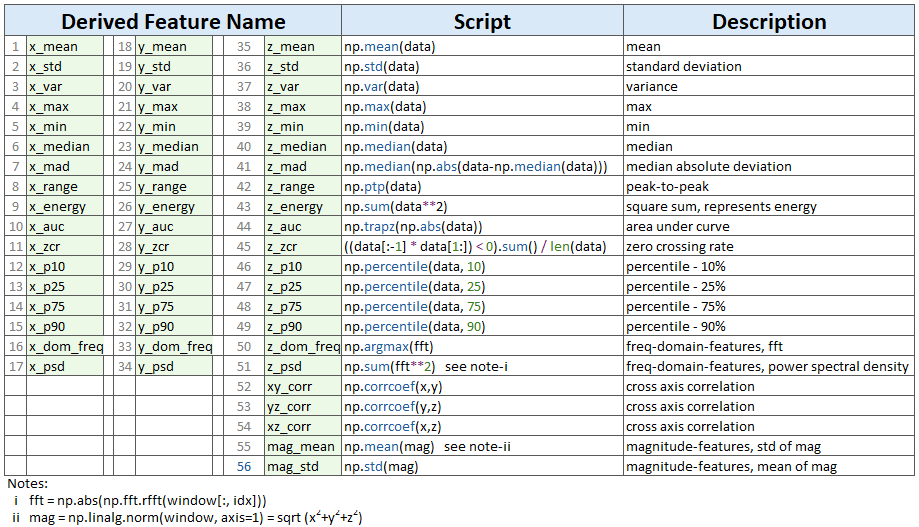

In [32]:
# Dataset Summary
print("\n==================== Dataset Summary ======================")
print(f"Total windows: {len(X_windows)}")
print(f"Window shape: {X_windows[0].shape}")
print(f"Features per window: {X_features.shape[1]}")
print(f"\nFeatures List:\n{X_features.iloc[0][:56].apply(lambda x: f"{float(x):.2f}")}")
print(f"\nActivity distribution:\n{pd.Series(y).value_counts()}")


==================== Dataset Summary ======================
Total windows: 9254
Window shape: (192, 3)
Features per window: 56

Features List:
x_mean              22.47
x_std                1.96
x_var                3.83
x_max               27.00
x_min               16.00
x_median            22.00
x_mad                1.00
x_range             11.00
x_energy         97711.00
x_auc             4290.50
x_zcr                0.00
x_p10               20.00
x_p25               21.00
x_p75               24.00
x_p90               25.00
y_mean              50.27
y_std                1.35
y_var                1.83
y_max               54.00
y_min               45.00
y_median            50.00
y_mad                1.00
y_range              9.00
y_energy        485465.00
y_auc             9601.00
y_zcr                0.00
y_p10               49.00
y_p25               49.75
y_p75               51.00
y_p90               52.00
z_mean              36.32
z_std                2.39
z_var                5.7

## 7.0 __EDA__ - Split Data, Apply Scaler on Data & Encode Labels

In [34]:
SCALER_PATH = os.path.join(local_joblib_model_dir, f"cnn_preprocess_pipeline_{get_timestamp()}.joblib")

# Split data (stratified to preserve class balance)
X_train_feat, X_test_feat, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)
# raw data for 1D-CNN classifier
X_train_raw, X_test_raw = X_windows[X_train_feat.index], X_windows[X_test_feat.index] 

# Build pipeline for CNN preprocessing
cnn_preprocess_pipeline = Pipeline([
    ('scaler', TimeSeriesScaler(StandardScaler()))
])
cnn_preprocess_pipeline.fit(X_train_raw)
# Save the fitted pipeline
joblib.dump(cnn_preprocess_pipeline, SCALER_PATH)
print(f"\nuploaded scaler in {SCALER_PATH}")

# Apply pipeline
X_train_raw = cnn_preprocess_pipeline.transform(X_train_raw)
X_test_raw  = cnn_preprocess_pipeline.transform(X_test_raw)

print("\nStandardScaler applied on X_train_raw (.fit_transform) and X_test_raw(.transform)")

print("\nVerification Prints ===================================")
print(f"X_train_feat.shape : {X_train_feat.shape}")
print(f"X_test_feat.shape  : {X_test_feat.shape}")
print(f"y_train.shape      : {y_train.shape}")
print(f"y_test.shape       : {y_test.shape}")
print(f"X_train_raw.shape  : {X_train_raw.shape}")
print(f"X_test_raw.shape   : {X_test_raw.shape}")

print("\nSplit data completed ==================================")

# Encode labels
encoder = LabelEncoder()
y_train_int = encoder.fit_transform(y_train)
y_test_int = encoder.transform(y_test)
print("\nverification prints:")
print(y_train[:2], y_test[:2])
print(y_train_int[:2], y_test_int[:2])
print("\nEncode data completed =================================")
# Get class names from encoder
class_names = encoder.classes_
print(f"\nclass_names: ==========================================\n {class_names}")
# Save the encoder in joblib_model directory
joblib.dump(encoder, os.path.join(local_joblib_model_dir, f"label_encoder_{get_timestamp()}.joblib"))
print(f"\ndownloaded encoder at : {local_joblib_model_dir}\label_encoder_{get_timestamp()}.joblib")


uploaded scaler in C:\Users\Ng Yong Huat\Documents\YH's HP PC\3 NYP\Applied AI\ITI-113 Project\Dataset\joblib_model\cnn_preprocess_pipeline_0824_2150.joblib

StandardScaler applied on X_train_raw (.fit_transform) and X_test_raw(.transform)

Verification Prints ===================================
X_train_feat.shape : (7403, 56)
X_test_feat.shape  : (1851, 56)
y_train.shape      : (7403,)
y_test.shape       : (1851,)
X_train_raw.shape  : (7403, 192, 3)
X_test_raw.shape   : (1851, 192, 3)

Split data completed ==================================

verification prints:
['Climb_stairs' 'Brush_teeth'] ['Drink_glass' 'Climb_stairs']
[1 0] [4 1]

Encode data completed =================================

class_names: ==========================================
 ['Brush_teeth' 'Climb_stairs' 'Comb_hair' 'Descend_stairs' 'Drink_glass'
 'Eat_meat' 'Eat_soup' 'Getup_bed' 'Liedown_bed' 'Pour_water'
 'Sitdown_chair' 'Standup_chair' 'Use_telephone' 'Walk']

downloaded encoder at : C:\Users\Ng Yong Huat\D

## 8.0 __Baseline Model__ - 1D-CNN Default Model

Epoch 1/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4100 - loss: 1.8376 - val_accuracy: 0.6078 - val_loss: 1.1352
Epoch 2/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5951 - loss: 1.1812 - val_accuracy: 0.6207 - val_loss: 1.0387
Epoch 3/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6234 - loss: 1.0720 - val_accuracy: 0.6661 - val_loss: 0.9535
Epoch 4/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6572 - loss: 0.9673 - val_accuracy: 0.6937 - val_loss: 0.8690
Epoch 5/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.6809 - loss: 0.8986 - val_accuracy: 0.7191 - val_loss: 0.8032
Epoch 6/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7084 - loss: 0.8264 - val_accuracy: 0.7272 - val_loss: 0.7578
Epoch 7/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7079 - loss: 0.7995 - val_accuracy: 0.7218 - val_loss: 0.7416
Epoch 8/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7267 - loss: 0.7568 - 

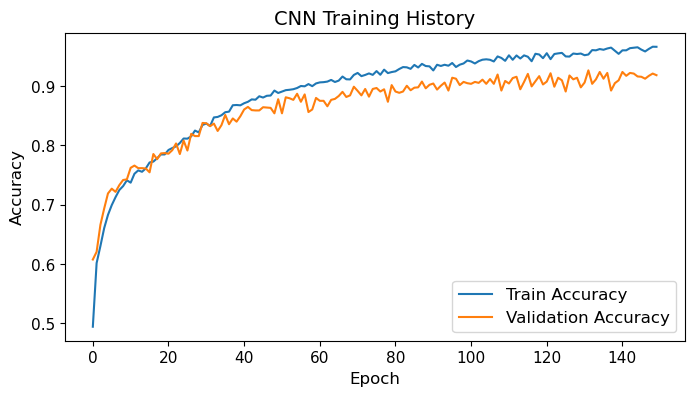

In [36]:
# Build CNN

hyperparams_dict = {
    "WINDOW_SIZE": WINDOW_SIZE,
    "STEP_SIZE": STEP_SIZE,
    "num_filters_1": 64,
    "num_filters_2": 128,
    "kernel_size": 3,
    "unit": 64,
    "batch_size": 32,
    "learning_rate": 0.001,
    "epochs": 150  
}
 
num_filters_1 = hyperparams_dict['num_filters_1']
num_filters_2 = hyperparams_dict['num_filters_2']
kernel_size   = hyperparams_dict['kernel_size']
unit          = hyperparams_dict['unit']
batch_size    = hyperparams_dict['batch_size']
learning_rate = hyperparams_dict['learning_rate']
epochs        = hyperparams_dict['epochs']


model = Sequential([
    Input(shape=(WINDOW_SIZE, 3)),
    Conv1D(num_filters_1, kernel_size, activation='relu'),
    MaxPooling1D(2),
    Conv1D(num_filters_2, kernel_size, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(unit, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy', # label should be integers
    metrics=['accuracy']
)

# Train the CNN, X_train_raw and X_test_raw already scaler-transformed
history = model.fit(
    X_train_raw, y_train_int,
    validation_data=(X_test_raw, y_test_int),
    epochs=epochs, 
    batch_size=batch_size,
    verbose=1
)

# Evaluate
y_pred_cnn = model.predict(X_test_raw).argmax(axis=1)
print("\n======================== 1D-CNN ==========================")
df_precision, acc_precision = sorted_classification_report(y_test_int, y_pred_cnn, class_names, sort_by='precision')
print(f"\nClassification Report sorted by precision\n{'=' * 58}")
print(df_precision)
print(f"\nAccuracy: {acc_precision:.3f}")  # Print accuracy
# Recall report
df_recall, acc_recall = sorted_classification_report(y_test_int, y_pred_cnn, class_names, sort_by='recall')
print(f"\nClassification Report sorted by recall\n{'=' * 58}")
print(df_recall)
print(f"\nAccuracy: {acc_recall:.3f}")
# F1-score report
df_f1, acc_f1 = sorted_classification_report(y_test_int, y_pred_cnn, class_names, sort_by='f1-score')
print(f"\nClassification Report sorted by f1-score\n{'=' * 58}")
print(df_f1)
print(f"\nAccuracy: {acc_f1:.3f}")

export_to_excel_2(y_test_int, y_pred_cnn, class_names, 
                  excel_filename=f"{local_eval_data_dir}/1dcnn_default.xlsx", 
                  hyperparams=hyperparams_dict)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 9.0 __Hyperparam Optimization__ 1D-CNN 

In [38]:
# split data
X_train_L, X_val_L, X_test_L, y_train_L, y_val_L, y_test_L, label_mapping = load_and_prepare_data(
    window_size=WINDOW_SIZE,
    step_size=STEP_SIZE
)

# Fit-transform training, transform validation/test
X_train_L = scaling_pipeline.fit_transform(X_train_L)
X_val_L   = scaling_pipeline.transform(X_val_L)
X_test_L  = scaling_pipeline.transform(X_test_L)

#verification prints:
print("\nVerification Prints ============================")
print(f"X_train_L.shape : {X_train_L.shape}")
print(f"y_train_L.shape : {y_train_L.shape}")
print(f"X_val_L.shape : {X_val_L.shape}")
print(f"y_val_L.shape : {y_val_L.shape}")
print(f"X_test_L.shape : {X_test_L.shape}")
print(f"y_test_L.shape : {y_test_L.shape}")
# ==== Hyperparameter grid ====
param_grid = {
    'num_filters_1': [32, 64],
    'num_filters_2': [64, 128],
    'kernel_size': [3, 5],
    'batch_size': [32, 64],
    'learning_rate': [0.001, 0.0005]
}

# Generate all combinations
param_combinations = list(product(*param_grid.values()))

results = []

# ==== Grid Search Loop ====
for params in param_combinations:
    num_filters_1, num_filters_2, kernel_size, batch_size, learning_rate = params
    print(f"\nTraining with params: {params}")

    # Build model
    model = build_cnn_opti(
        input_shape=X_train_L.shape[1:],
        num_classes=len(np.unique(y_train_L)),
        num_filters_1=num_filters_1,
        num_filters_2=num_filters_2,
        kernel_size=kernel_size,
        learning_rate=learning_rate
    )

    

    # Train model
    history = model.fit(
        X_train_L, y_train_L, 
        validation_data= (X_val_L, y_val_L),
        epochs= 120,
        batch_size= batch_size,
        verbose= 0
    )

    # Evaluate
    y_val_pred = model.predict(X_val_L).argmax(axis=1)
    val_acc = accuracy_score(y_val_L, y_val_pred)
    val_f1 = f1_score(y_val_L, y_val_pred, average='macro')

    # Save results
    results.append({
        'num_filters_1': num_filters_1,
        'num_filters_2': num_filters_2,
        'kernel_size': kernel_size,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'val_accuracy': val_acc,
        'val_macro_f1': val_f1
    })

# ==== Save & Find Best ====
results_df = pd.DataFrame(results)
results_df.sort_values(by=['val_macro_f1', 'val_accuracy'], ascending=False, inplace=True)
results_df.to_excel(f"1dcnn_hyP_opti_{get_timestamp()}.xlsx", index=False)
best_params = results_df.iloc[0]

print(results_df)

print("\nGrid-Search Hyperparameters:")
print(results_df.iloc[0])


Label mapping: {'Brush_teeth': 0, 'Climb_stairs': 1, 'Comb_hair': 2, 'Descend_stairs': 3, 'Drink_glass': 4, 'Eat_meat': 5, 'Eat_soup': 6, 'Getup_bed': 7, 'Liedown_bed': 8, 'Pour_water': 9, 'Sitdown_chair': 10, 'Standup_chair': 11, 'Use_telephone': 12, 'Walk': 13}

Verification Prints ============================
X_train_L.shape : (6472, 192, 3)
y_train_L.shape : (6472,)
X_val_L.shape : (1387, 192, 3)
y_val_L.shape : (1387,)
X_test_L.shape : (1388, 192, 3)
y_test_L.shape : (1388,)

Training with params: (32, 64, 3, 32, 0.001)
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training with params: (32, 64, 3, 32, 0.0005)
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Training with params: (32, 64, 3, 64, 0.001)
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Training with params: (32, 64, 3, 64, 0.0005)
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training with params: (32, 64, 5, 32, 0.001)
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Training with params: (32, 64, 5, 32, 0.0005)
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

T

## 10.0 __Best Model__ - 1D-CNN

Epoch 1/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4401 - loss: 1.7341 - val_accuracy: 0.5905 - val_loss: 1.1553
Epoch 2/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5964 - loss: 1.1536 - val_accuracy: 0.6494 - val_loss: 0.9701
Epoch 3/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6389 - loss: 1.0075 - val_accuracy: 0.6326 - val_loss: 0.9607
Epoch 4/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6840 - loss: 0.9118 - val_accuracy: 0.6899 - val_loss: 0.8084
Epoch 5/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6991 - loss: 0.8215 - val_accuracy: 0.7283 - val_loss: 0.7530
Epoch 6/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7186 - loss: 0.7722 - val_accuracy: 0.7385 - val_loss: 0.6910
Epoch 7/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7402 - loss: 0.7048 - val_accuracy: 0.7580 - val_loss: 0.6540
Epoch 8/150
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7537 - loss: 0.6554 - 

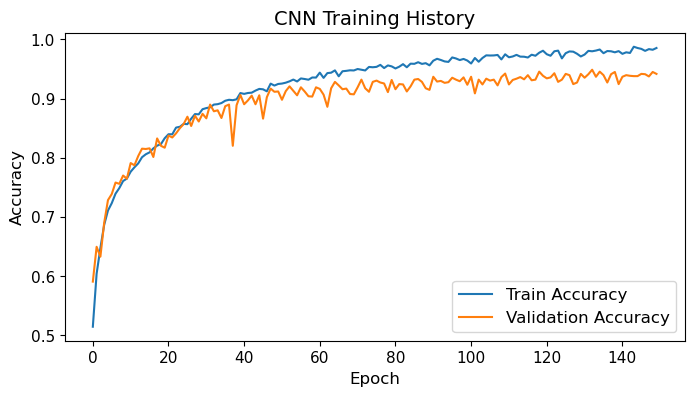

Model saved to C:\Users\Ng Yong Huat\Documents\YH's HP PC\3 NYP\Applied AI\ITI-113 Project\Dataset\joblib_model/best_1dcnn_model_0824_2358.h5


In [40]:
# Best_1D_CNN model

best_params = results_df.iloc[0]
# Best model parameters:
WINDOW_SIZE   = WINDOW_SIZE
STEP_SIZE     = STEP_SIZE
num_filters_1 = int(best_params["num_filters_1"])
num_filters_2 = int(best_params["num_filters_2"])
kernel_size   = int(best_params["kernel_size"])
batch_size    = int(best_params["batch_size"])
learning_rate = float(best_params["learning_rate"])

model = Sequential([
    Input(shape=(WINDOW_SIZE, 3)),
    Conv1D(num_filters_1, kernel_size, activation='relu'),
    MaxPooling1D(2),
    Conv1D(num_filters_2, kernel_size, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy', # label should be integers
    metrics=['accuracy']
)

# 4. Train the CNN, data from 6.0 Split data, 80% train, 20% test
history = model.fit(
    X_train_raw, y_train_int,
    validation_data= (X_test_raw, y_test_int),
    epochs= 150,
    batch_size= batch_size,
    verbose= 1
)

# Evaluate
y_pred_cnn = model.predict(X_test_raw).argmax(axis=1)
print("\n================== 1D-CNN ===================")
df_precision, acc_precision = sorted_classification_report(y_test_int, y_pred_cnn, class_names, sort_by='precision')
print(f"\nClassification Report sorted by precision\n{'=' * 58}")
print(df_precision)
print(f"\nAccuracy: {acc_precision:.3f}")  # Print accuracy
# Recall report
df_recall, acc_recall = sorted_classification_report(y_test_int, y_pred_cnn, class_names, sort_by='recall')
print(f"\nClassification Report sorted by recall\n{'=' * 58}")
print(df_recall)
print(f"\nAccuracy: {acc_recall:.3f}")
# F1-score report
df_f1, acc_f1 = sorted_classification_report(y_test_int, y_pred_cnn, class_names, sort_by='f1-score')
print(f"\nClassification Report sorted by f1-score\n{'=' * 58}")
print(df_f1)
print(f"\nAccuracy: {acc_f1:.3f}")

hyperparams_dict = {
    "WINDOW_SIZE": WINDOW_SIZE,
    "STEP_SIZE": STEP_SIZE,
    "num_filters_1": num_filters_1,
    "num_filters_2": num_filters_2,
    "kernel_size": kernel_size,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "epochs": len(history.history['accuracy'])
}
export_to_excel_2(y_test_int, y_pred_cnn, class_names, 
                  excel_filename=f"{local_eval_data_dir}/1dcnn_best.xlsx", 
                  hyperparams=hyperparams_dict)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model.save(f"{local_joblib_model_dir}/best_1dcnn_model_{get_timestamp()}.h5")
print(f"Model saved to {local_joblib_model_dir}/best_1dcnn_model_{get_timestamp()}.h5")

# to load back:
# from tensorflow.keras.models import load_model, Sequential
# loaded_model = load_model(f"{local_eval_data_dir}/best_1dcnn_model.h5")

## 11.0 __Baseline Model__ - RandomForest Default Model

In [42]:
# Train RF
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_feat, y_train_int)
    
# Save the model with timestamp
model_path = f"{local_joblib_model_dir}/rf_default_{get_timestamp()}.joblib"
dump(rf, model_path)

# --- Find the latest model file ---
pattern = os.path.join(local_joblib_model_dir, "rf_default_*.joblib")
latest_model = max(glob.glob(pattern), key=os.path.getmtime)

# Load the latest model
loaded_rf = load(latest_model)
print(f"Loaded latest model: {latest_model}")
# Evaluate
y_pred_rf = loaded_rf.predict(X_test_feat)


Loaded latest model: C:\Users\Ng Yong Huat\Documents\YH's HP PC\3 NYP\Applied AI\ITI-113 Project\Dataset\joblib_model\rf_default_0824_2358.joblib


In [43]:
# print and file classification report with accuracy reading
df_precision, acc_precision = sorted_classification_report(y_test_int, y_pred_rf, class_names, sort_by='precision')
print(f"\nClassification Report sorted by precision\n{'=' * 58}")
print(df_precision)
print(f"\nAccuracy: {acc_precision:.3f}")  # Print accuracy
# Recall report
df_recall, acc_recall = sorted_classification_report(y_test_int, y_pred_rf, class_names, sort_by='recall')
print(f"\nClassification Report sorted by recall\n{'=' * 58}")
print(df_recall)
print(f"\nAccuracy: {acc_recall:.3f}")
# F1-score report
df_f1, acc_f1 = sorted_classification_report(y_test_int, y_pred_rf, class_names, sort_by='f1-score')
print(f"\nClassification Report sorted by f1-score\n{'=' * 58}")
print(df_f1)
print(f"\nAccuracy: {acc_f1:.3f}")
# export sorted classification report to archive local folder in excel format
export_to_excel_2(y_test_int, y_pred_rf, class_names,
    os.path.join(local_eval_data_dir, "rf_default.xlsx")
)


Classification Report sorted by precision
             class  precision  recall  f1-score  support
0      Brush_teeth      0.968   0.976     0.972    124.0
1        Comb_hair      0.938   0.938     0.938     97.0
2         Eat_meat      0.934   0.992     0.962    129.0
3    Use_telephone      0.933   0.889     0.911     63.0
4      Drink_glass      0.931   0.910     0.920    178.0
5   Descend_stairs      0.930   0.841     0.883     63.0
6         Eat_soup      0.926   0.926     0.926     27.0
7       Pour_water      0.916   0.948     0.932    173.0
8             Walk      0.914   0.974     0.943    384.0
9     Climb_stairs      0.903   0.784     0.840    167.0
10     Liedown_bed      0.824   0.298     0.438     47.0
11       Getup_bed      0.741   0.858     0.795    190.0
12   Standup_chair      0.723   0.695     0.709    105.0
13   Sitdown_chair      0.699   0.692     0.696    104.0

Accuracy: 0.879

Classification Report sorted by recall
             class  precision  recall  f1-sco

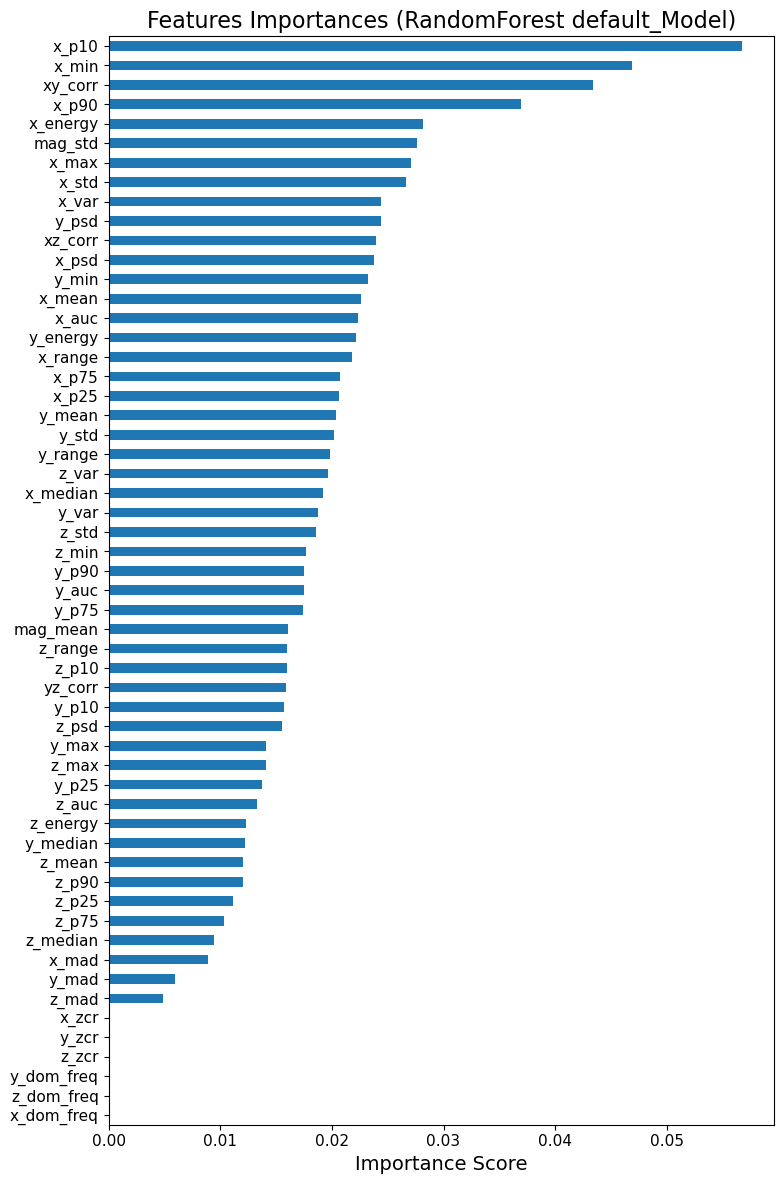


Features importance:
Feature                        Factor    
x_p10                                5.68
x_min                                4.69
xy_corr                              4.34
x_p90                                3.70
x_energy                             2.81
mag_std                              2.76
x_max                                2.71
x_std                                2.66
x_var                                2.44
y_psd                                2.44
xz_corr                              2.39
x_psd                                2.38
y_min                                2.32
x_mean                               2.26
x_auc                                2.23
y_energy                             2.22
x_range                              2.18
x_p75                                2.08
x_p25                                2.06
y_mean                               2.03
y_std                                2.02
y_range                              1.98
z_var       

In [44]:
# Feature Importance
plt.figure(figsize=(8, 12))
#pd.Series(rf.feature_importances_, index=X_train_feat.columns).sort_values().tail(20).plot.barh()
(pd.Series(rf.feature_importances_, index=X_train_feat.columns)
   .sort_values()
   .plot.barh())
plt.title("Features Importances (RandomForest default_Model)",fontsize=16.0)
plt.xlabel("Importance Score",fontsize=14.0)
plt.tight_layout()
plt.show()

list_n_file_feat_importance(
    rf, 
    X_train_feat.columns, 
    output_dir=local_eval_data_dir,
    output_filename="rf_feature_importance"
)

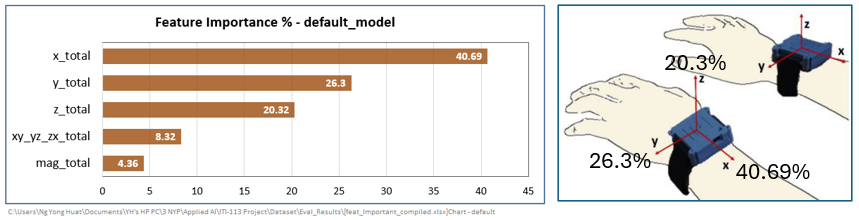

## 12.0 __HyperParam Opti__ - RandomForest 

In [47]:
# using gridsearch to optimize hyperparameters.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(bootstrap=True, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300], # default = 100 
    'max_depth': [None, 10, 20],  # default = None
    'min_samples_split': [2, 5], # default = 2
    'min_samples_leaf': [1, 2],   # default = 1
    'max_samples': [0.7, None],      # default = None
    'class_weight': ['balanced', None],  # default = None
    'max_features': ['sqrt', 'log2'],
}

grid = GridSearchCV(
    estimator=rf,    
    param_grid=param_grid,
    cv=cv,               
    n_jobs=-1,
    verbose=2,
) 

grid.fit(X_train_feat, y_train_int)
print("Best params:", grid.best_params_)
print("Best CV f1_weighted:", grid.best_score_)



Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best params: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV f1_weighted: 0.8650541088015767


## 13.0 __Best Model__ - RandomForest 

In [49]:
# --- Evaluate on test set ---
best_model_rf = grid.best_estimator_
y_prob_rf = best_model_rf.predict_proba(X_test_feat)[:, 1]
y_pred_rf = best_model_rf.predict(X_test_feat)

# sort by [precision, recall, f1-score
df_precision, acc_precision = sorted_classification_report(y_test_int, y_pred_rf, class_names, sort_by='precision')
print(f"\nClassification Report sorted by precision\n{'=' * 58}")
print(df_precision)
print(f"\nAccuracy: {acc_precision:.3f}")  # Print accuracy

# Recall report
df_recall, acc_recall = sorted_classification_report(y_test_int, y_pred_rf, class_names, sort_by='recall')
print(f"\nClassification Report sorted by recall\n{'=' * 58}")
print(df_recall)
print(f"\nAccuracy: {acc_recall:.3f}")

# F1-score report
df_f1, acc_f1 = sorted_classification_report(y_test_int, y_pred_rf, class_names, sort_by='f1-score')
print(f"\nClassification Report sorted by f1-score\n{'=' * 58}")
print(df_f1)
print(f"\nAccuracy: {acc_f1:.3f}")

export_to_excel_2(y_test_int, y_pred_rf, class_names,
    os.path.join(local_eval_data_dir, "rf_best.xlsx")
)

# Save best model to local folder as archive
joblib.dump(best_model_rf, f"{local_joblib_model_dir}/best_rf_model_{get_timestamp()}.joblib")
print(f"\nBest RF model saved to {local_joblib_model_dir}/best_rf_model_{get_timestamp()}.joblib")
                                                          


Classification Report sorted by precision
             class  precision  recall  f1-score  support
0      Brush_teeth      0.983   0.952     0.967    124.0
1    Use_telephone      0.982   0.889     0.933     63.0
2   Descend_stairs      0.965   0.873     0.917     63.0
3         Eat_meat      0.941   0.992     0.966    129.0
4        Comb_hair      0.938   0.928     0.933     97.0
5      Drink_glass      0.932   0.921     0.927    178.0
6         Eat_soup      0.926   0.926     0.926     27.0
7     Climb_stairs      0.923   0.784     0.848    167.0
8             Walk      0.910   0.974     0.941    384.0
9       Pour_water      0.896   0.942     0.918    173.0
10     Liedown_bed      0.810   0.362     0.500     47.0
11       Getup_bed      0.749   0.879     0.809    190.0
12   Standup_chair      0.724   0.676     0.700    105.0
13   Sitdown_chair      0.705   0.712     0.708    104.0

Accuracy: 0.882

Classification Report sorted by recall
             class  precision  recall  f1-sco

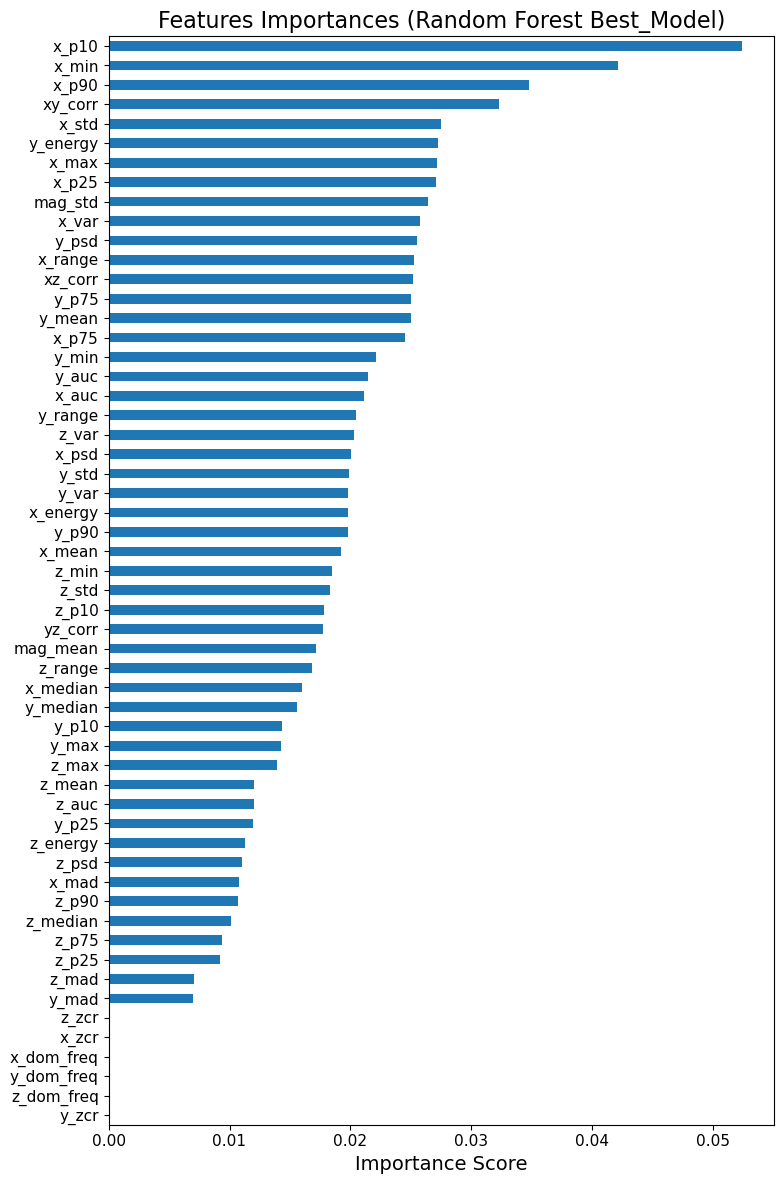


Features importance:
Feature                        Factor    
x_p10                                5.24
x_min                                4.21
x_p90                                3.47
xy_corr                              3.22
x_std                                2.75
y_energy                             2.73
x_max                                2.71
x_p25                                2.71
mag_std                              2.64
x_var                                2.57
y_psd                                2.55
x_range                              2.53
xz_corr                              2.51
y_p75                                2.50
y_mean                               2.50
x_p75                                2.45
y_min                                2.21
y_auc                                2.14
x_auc                                2.11
y_range                              2.04
z_var                                2.03
x_psd                                2.00
y_std       

In [50]:
# Feature Importance
plt.figure(figsize=(8, 12))
#pd.Series(rf.feature_importances_, index=X_train_feat.columns).sort_values().tail(20).plot.barh()
(pd.Series(best_model_rf.feature_importances_, index=X_train_feat.columns)
   .sort_values()
   .plot.barh())
plt.title("Features Importances (Random Forest Best_Model)",fontsize=16.0)
plt.xlabel("Importance Score",fontsize=14.0)
plt.tight_layout()
plt.show()

list_n_file_feat_importance(
    best_model_rf, 
    X_train_feat.columns, 
    output_dir=local_eval_data_dir,
    output_filename="rf_best_Model_feature_importance"
)

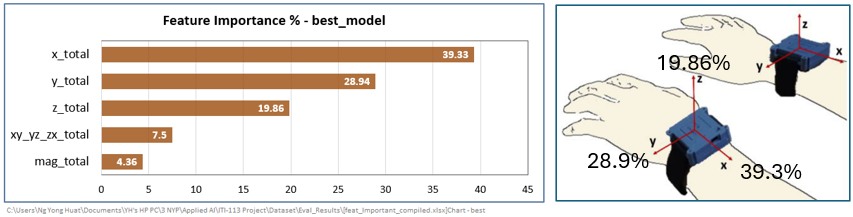

## 14.0 __Performance Comparison__ -Confusion Matrix, Classification Report

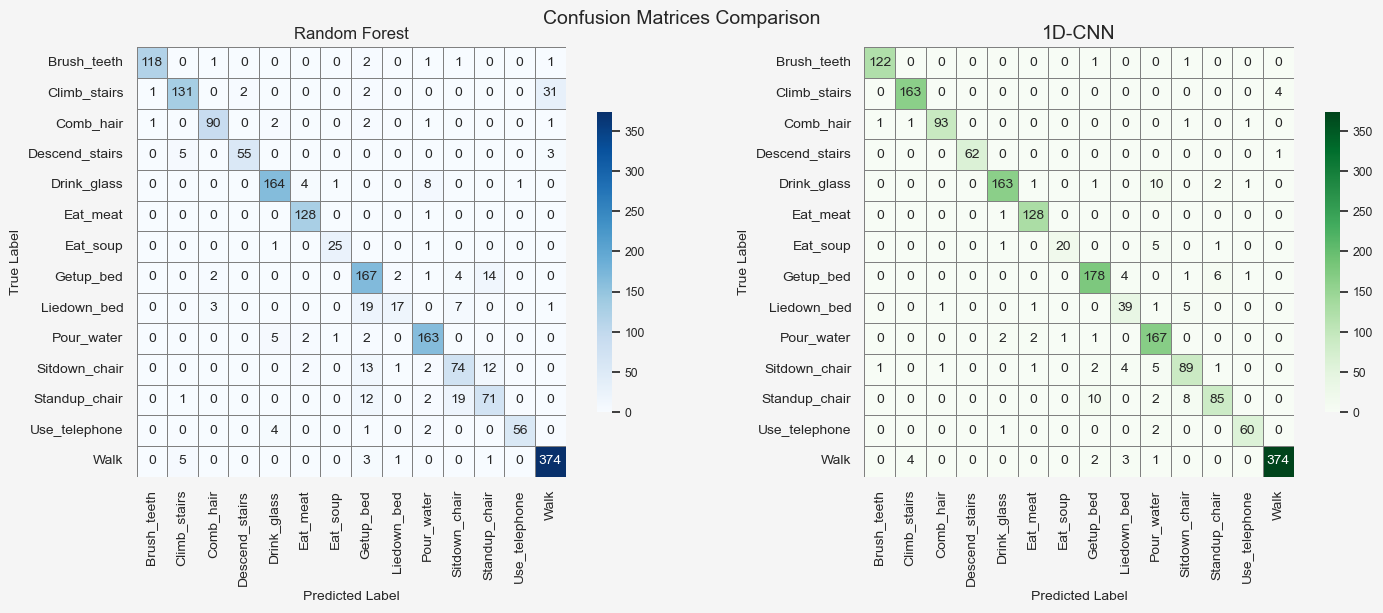

In [53]:
# Set the font scale for seaborn
sns.set(font_scale=0.8)  # Adjust this value (0.5-1.2) as needed

# Set seaborn style and font scale
sns.set(style='whitegrid', font_scale=0.8)

# Side-by-Side Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_facecolor('#f5f5f5')  # Light gray background for the whole figure

# RF Confusion Matrix
sns.heatmap(confusion_matrix(y_test_int, y_pred_rf), 
            annot=True, 
            fmt='d', 
            ax=ax1,
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 10},  # Annotation (numbers) font size
            cbar_kws={"shrink": 0.7},  # Color bar size
            linewidths=0.5,        # Gridlines
            linecolor='gray',      # Gridline color
            square=True,           # Make each cell square
            cmap='Blues'           # Optional: use a color palette
           )
ax1.set_title('Random Forest', fontsize=14)  # Title font size)
ax1.tick_params(axis='both', labelsize=10)  # Tick label size

ax1.set_title('Random Forest', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=10)
ax1.set_ylabel('True Label', fontsize=10)
ax1.tick_params(axis='both', labelsize=10)
ax1.set_facecolor('#ffffff')  # White background for just the heatmap

# CNN Confusion Matrix
sns.heatmap(confusion_matrix(y_test_int, y_pred_cnn), 
            annot=True, 
            fmt='d', 
            ax=ax2,
            xticklabels=class_names,
            yticklabels=class_names,            
            annot_kws={"size": 10},
            cbar_kws={"shrink": 0.7},
            linewidths=0.5,        # Gridlines
            linecolor='gray',      # Gridline color
            square=True,           # Make each cell square
            cmap='Greens'           # Optional: use a color palette
           )
ax2.set_title('1D-CNN', fontsize=14)
ax2.set_xlabel('Predicted Label', fontsize=10)
ax2.set_ylabel('True Label', fontsize=10)
ax2.tick_params(axis='both', labelsize=10)
ax2.set_facecolor('#ffffff')

plt.suptitle('Confusion Matrices Comparison', fontsize=14)

plt.tight_layout()  # Prevent overlapping elements
plt.show()

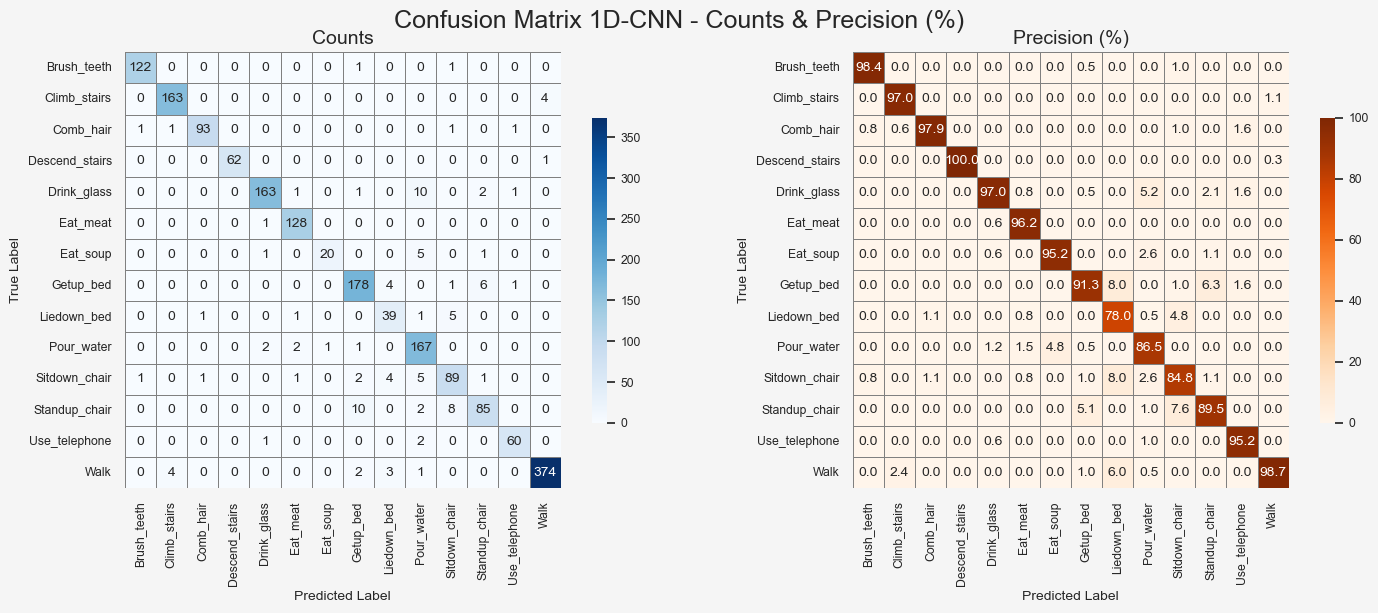

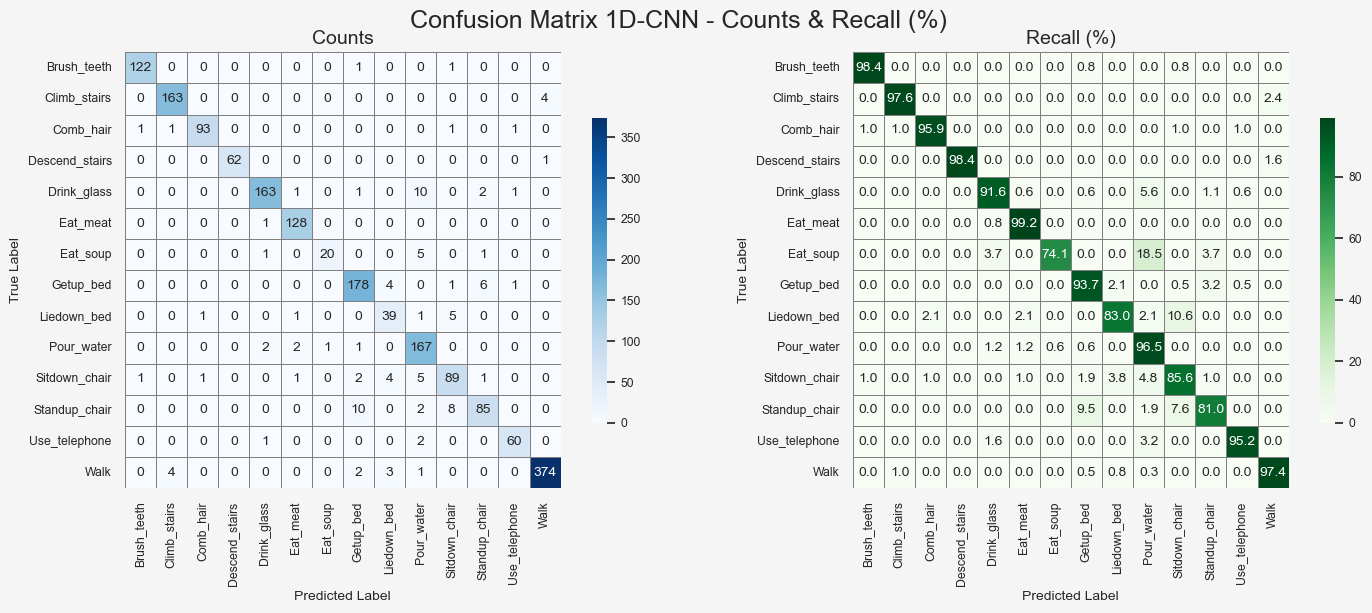

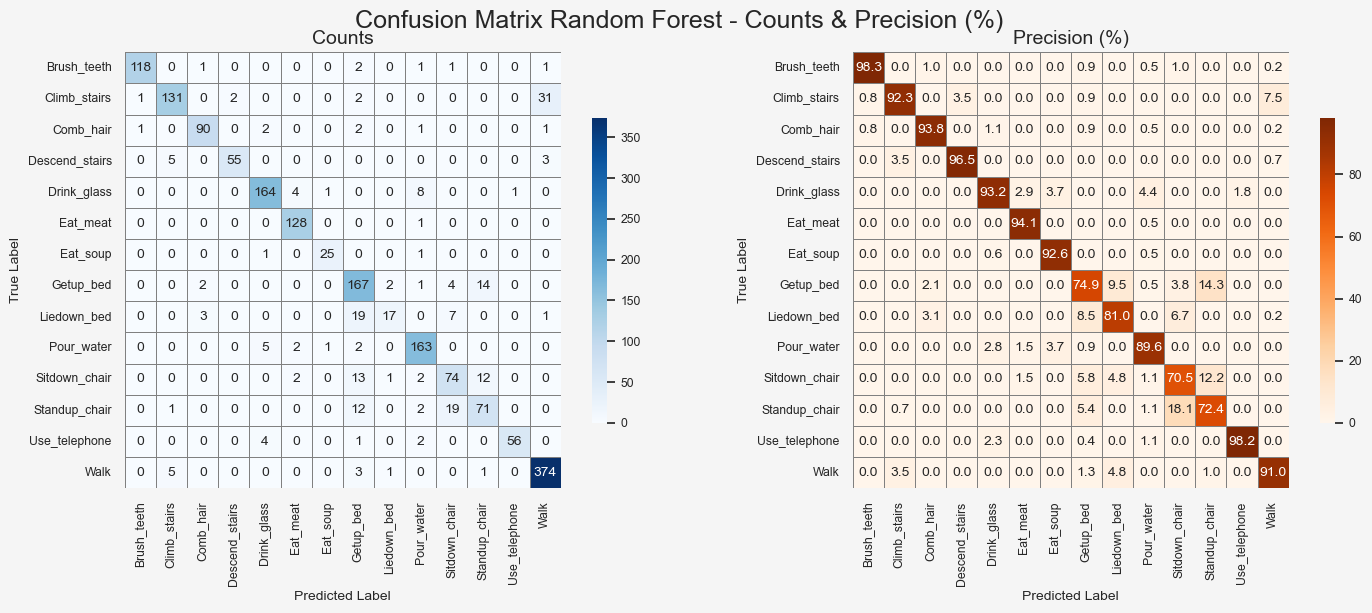

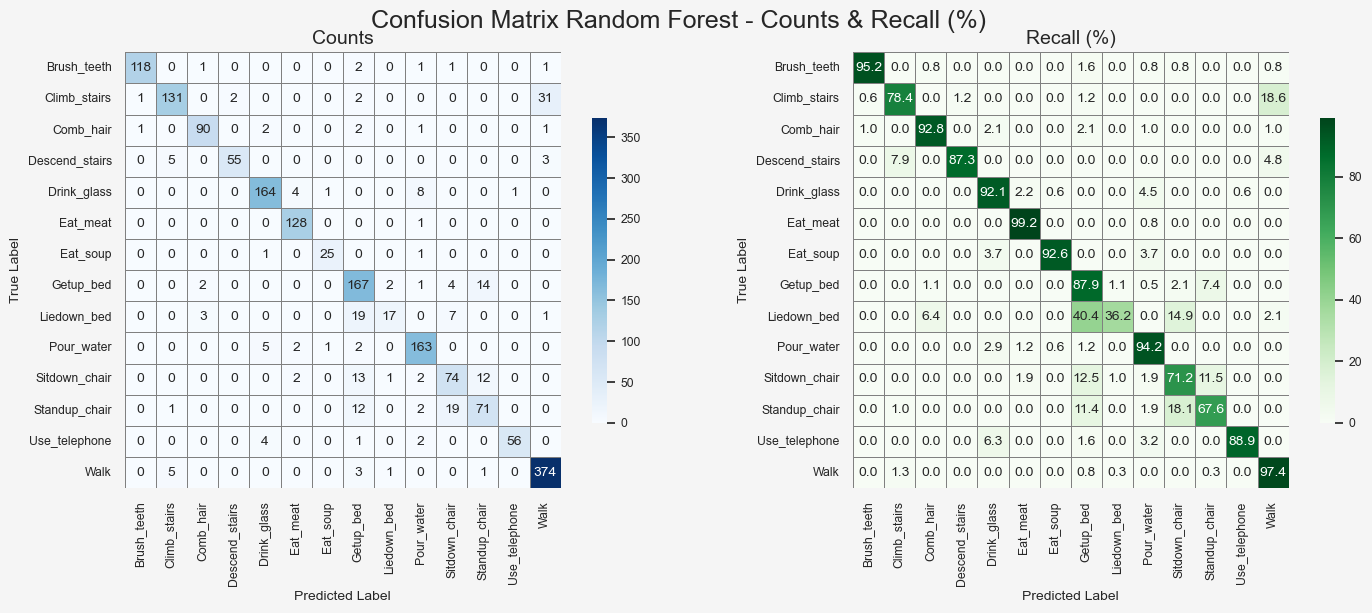

In [54]:
from utils import plot_confusion_matrices
plot_confusion_matrices(y_test_int, y_pred_cnn, class_names, model_name="1D-CNN")
plot_confusion_matrices(y_test_int, y_pred_rf, class_names, model_name="Random Forest")

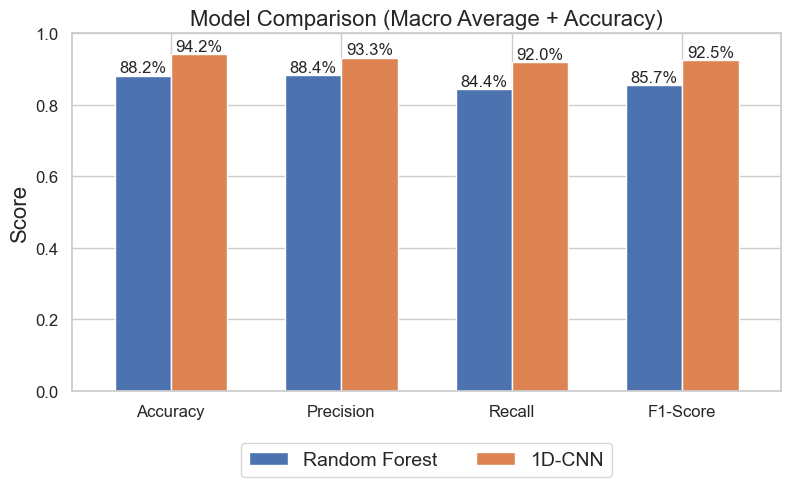

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
from utils import get_metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Example data
metrics_rf = get_metrics(y_test_int, y_pred_rf)
metrics_cnn = get_metrics(y_test_int, y_pred_cnn)

df_metrics = pd.DataFrame({
    'Random Forest': metrics_rf,
    '1D-CNN': metrics_cnn
})

# --- Customization parameters ---
legend_font_size = 14
value_font_size = 12
bar_width = 0.6 * 1.1  # original 0.8 width increased by 20%

# --- Plot ---
ax = df_metrics.plot.bar(
    rot=0, 
    figsize=(8, 5), 
    width=bar_width
)

plt.title('Model Comparison (Macro Average + Accuracy)',fontsize=16)
plt.ylabel('Score',fontsize=16)
plt.ylim(0, 1)
ax.tick_params(axis='both', labelsize=12)  # Tick label size


# Move legend to bottom
plt.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.12), 
    ncol=len(df_metrics.columns), 
    fontsize=legend_font_size
)

# Add value labels
for p in ax.patches:
    ax.annotate(
#        f"{p.get_height():.2f}",
        f"{p.get_height()*100:.1f}%",
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center', va='bottom', 
        fontsize=value_font_size
    )

plt.tight_layout()
plt.show()

## 15.0 McNemar's Hypothesis Test

In [57]:
# Calculate overall accuracy
rf_accuracy = accuracy_score(y_test_int, y_pred_rf)
cnn_accuracy = accuracy_score(y_test_int, y_pred_cnn)
print(f"RF Accuracy:      {rf_accuracy:.3f}")
print(f"1D- CNN Accuracy: {cnn_accuracy:.3f}")

# Create arrays of correctness (1 for correct, 0 for wrong)
rf_correct = (y_test_int == y_pred_rf).astype(int)
cnn_correct = (y_test_int == y_pred_cnn).astype(int)

# Now, we count the four scenarios:
# a: Both correct (RF correct AND CNN correct)
a = np.sum((rf_correct == 1) & (cnn_correct == 1))

# b: RF correct but CNN wrong
b = np.sum((rf_correct == 1) & (cnn_correct == 0))

# c: RF wrong but CNN correct
c = np.sum((rf_correct == 0) & (cnn_correct == 1))

# d: Both wrong
d = np.sum((rf_correct == 0) & (cnn_correct == 0))

# Create the contingency table as a 2x2 numpy array
contingency_table = np.array([[a, b],
                              [c, d]])

print("\nContingency Table for McNemar's Test:")
print(" [[a b]")
print("  [c d]] =")
print(contingency_table)

from statsmodels.stats.contingency_tables import mcnemar

# Calculate McNemar's test
result = mcnemar(contingency_table, exact=False, correction=True) # Use correction for continuity

# Print the results
print(f"Statistic:, {result.statistic:.3f}")
print(f"p-value:  , {result.pvalue:.3f}")

# Interpret the results
alpha = 0.05
print(f"\nSignificance Level: α = {alpha}")
if result.pvalue > alpha:
    print('\nFail to reject the null hypothesis (H₀). There is no significant difference between the models.')
else:
    print('\nReject the null hypothesis (H₀). \nThere is a significant difference between the models.')
    # You can now look at the original accuracies to see which one is better.
    if rf_accuracy > cnn_accuracy:
        print("RandomForest is statistically significantly better.")
    else:
        print("\n1DCNN is statistically significantly better.")

RF Accuracy:      0.882
1D- CNN Accuracy: 0.942

Contingency Table for McNemar's Test:
 [[a b]
  [c d]] =
[[1585   48]
 [ 158   60]]
Statistic:, 57.675
p-value:  , 0.000

Significance Level: α = 0.05

Reject the null hypothesis (H₀). 
There is a significant difference between the models.

1DCNN is statistically significantly better.


## 16.0 Deployment - streamlit_app.py

__Steps to Perform Inference with Input file__
1. In Python environment, run the streamlit_app.py  
2. Open a command line window pointing to the same directory.  
3. PS local directory> streamlit run streamlit_app.py  
4. A webpage will be opened as shown  
5. Drag in the input file and click   

In [59]:
#!pip install streamlit

In [60]:
%%writefile streamlit_app.py
import joblib
import streamlit as st
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from utils import create_sliding_windows, TimeSeriesScaler  # make sure TimeSeriesScaler is in utils
from constants import local_joblib_model_dir

# ===== Config =====
class_names = ['Brush_teeth', 'Climb_stairs', 'Comb_hair', 'Descend_stairs', 'Drink_glass',
 'Eat_meat', 'Eat_soup', 'Getup_bed', 'Liedown_bed', 'Pour_water',
 'Sitdown_chair', 'Standup_chair', 'Use_telephone', 'Walk']

window_size = 192
step_size = 48

# ===== Load 1D-CNN Model =====
cnn_model = load_model(f"{local_joblib_model_dir}/best_1dcnn_model_0813_1251.h5")
# ===== Load pre-fitted scaler pipeline =====
scaler_path = f"{local_joblib_model_dir}/cnn_preprocess_pipeline.joblib"
scaling_pipeline = joblib.load(scaler_path)


# ===== Streamlit UI =====
st.title("HMP Classification with Accelerometer Data (1D-CNN)")

st.write(f"Window Size: {window_size}, Step Size: {step_size}")

# File uploader
uploaded_file = st.file_uploader("Upload Accelerometer Data (.txt)", type=["txt"])

if uploaded_file is not None:
    # Read TXT file, space-separated, no header
    df = pd.read_csv(uploaded_file, sep=r"\s+", header=None, names=["x", "y", "z"])
    st.write("Uploaded Data Preview:")
    st.dataframe(df.head())

    # Convert to numpy array
    data_array = df[["x", "y", "z"]].to_numpy()

    # Dummy labels for sliding windows
    dummy_labels = np.zeros(len(data_array))

    # Create sliding windows
    X_windows, _ = create_sliding_windows(data_array, dummy_labels, window_size, step_size, label_strategy="last")
    st.write(f"Created {X_windows.shape[0]} windows, each with shape {X_windows.shape[1:]}")

    # Apply scaler pipeline (transform only, no fitting!)
    X_scaled = scaling_pipeline.transform(X_windows)
    
    # Predict button
    if st.button("Predict"):
        # CNN expects (samples, timesteps, features)
        X_cnn = X_scaled.reshape(X_scaled.shape[0], window_size, 3)
        predictions = np.argmax(cnn_model.predict(X_cnn), axis=1)
        pred_names = [class_names[i] for i in predictions]

        st.success("Prediction Completed")
        st.write("Predicted classes for each window:")
        st.write(pred_names)

Overwriting streamlit_app.py
